In [1]:
import torch
from PIL import Image
import pathlib
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import time

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 2.2.0.dev20231001 CPU


In [2]:
from ultralytics import YOLO

In [3]:
model = YOLO('yolov8n')

In [4]:
import math
# Run Algo for processing
def calculate_pre(rois):
    # find bounding rect of all rois
    rects = [cv2.boundingRect(r) for r in rois]
    dims = math.ceil(math.sqrt(len(rects)))

    # Now find the mappings
    # return a list of source_x, source_y, dest_x, dest_y, w, h
    ans = []
    x_cur = 0
    y_cur = 0

    w_max = 0
    h_max = 0
    adsroi = []
    for idx, (rect, roi) in enumerate(zip(rects, rois)):
        # find rows to remove from image
        idx += 1
        x, y, w, h = rect

        off_x = x - x_cur
        off_y = y  - y_cur
        
        ans.append([x, y, x_cur, y_cur, w, h])

        adsroi.append(np.array([(x - off_x, y - off_y) for x, y, in roi]))
        
        x_cur += w

        if w_max < x_cur:
            w_max = x_cur

        if h_max < y_cur + h:
            h_max = y_cur + h
        
        if (dims != 1 and idx % dims == 0) or (dims == 1 and idx == dims):
            y_cur += h
            x_cur = 0
        
    return ans, (w_max, h_max), adsroi

def pre_process(image, ans, w, h):
    new_img = np.ones((h,w,3), np.uint8) * 255
    
    return new_img

def draw_contours(new_img, rois):
    new_img_2 = np.ones(new_img.shape, np.uint8) * 255
    mask_0 = np.ones(new_img.shape[:-1], np.uint8)
    for roi in rois:
        mask = np.ones(new_img.shape[:-1], np.uint8)
        cv2.drawContours(mask, [roi], -1, 0, -1, cv2.LINE_AA)
        cv2.drawContours(new_img_2, [roi], -1, (0, 0, 0), -1, cv2.LINE_AA)
        mask_0 += mask

       
    new_img_2 = cv2.bitwise_or(new_img, new_img_2, mask=mask_0)
    return new_img_2


def pre_processroi(image, rois, ans, w, h):
    new_img = np.ones((h,w,3), np.uint8) * 255
    for source_x, source_y, dest_x, dest_y, w, h in ans:
        new_img[dest_y: dest_y + h, dest_x: dest_x + w] = image[source_y:source_y + h, source_x : source_x+ w]
    
    return draw_contours(new_img, rois)

In [5]:
def time_profile_other_no_crop(path, ans, rois, imgsz = (640, 640)):
    timings = []
    processings = []
    print(imgsz)
    cap = cv2.VideoCapture(path)
    count = 0
    old_frame = None
    while cap.isOpened():
        ret,frame = cap.read()
        if not ret:
            break
        
        t1 = time.time()
        frame = draw_contours(frame, rois)
        t2 = time.time()
        
        processings.append(t2 - t1)
        
        old_frame = frame
        
        t1 = time.time()
        model.predict(frame, imgsz=imgsz, show=False)
        t2 = time.time()
        
        timings.append(t2 - t1)
        
        #cv2.imshow('video', frame)
        count = count + 1
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cv2.imwrite("framenocrop.jpg", old_frame)        
    
    cap.release()
    cv2.destroyAllWindows() # destroy all opened windows

    return timings, processings

In [6]:
def time_profile_other_crop(path, ans, rois, imgsz = (640, 640)):
    timings = []
    processings = []
    print(imgsz)
    cap = cv2.VideoCapture(path)
    count = 0
    old_frame = None
    while cap.isOpened():
        ret,frame = cap.read()
        if not ret:
            break
        
        t1 = time.time()
        frame = pre_processroi(frame, rois, ans, imgsz[0], imgsz[1])
        t2 = time.time()
        
        processings.append(t2 - t1)
        
        old_frame = frame
        
        t1 = time.time()
        model.predict(frame, imgsz=imgsz, show=False)
        t2 = time.time()
        
        timings.append(t2 - t1)
        
        #cv2.imshow('video', frame)
        count = count + 1
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cv2.imwrite("frameoccrop.jpg", old_frame)    
    
    cap.release()
    cv2.destroyAllWindows() # destroy all opened windows

    return timings, processings

In [7]:
pth = 'movienocrop.mp4'
# rois = [np.array([[0, 0], [0, 317], [640, 317], [640, 0]]),
  #              np.array([[277 * scale_factor, (380 - crop_h) * scale_factor],[410 * scale_factor, (392 - crop_h)* scale_factor],[381* scale_factor, (506 - crop_h)* scale_factor],[155* scale_factor, (498 - crop_h)* scale_factor]]),
   #             np.array([[97* scale_factor, 0],[97* scale_factor, (365 - crop_h)* scale_factor],[160* scale_factor, (390 - crop_h)* scale_factor],[0, (462 - crop_h)* scale_factor], [0, 0]]),
    #            np.array([[556* scale_factor, 0],[556* scale_factor, (365 - crop_h)* scale_factor],[504* scale_factor, (370 - crop_h)* scale_factor],[542* scale_factor, (444 - crop_h)* scale_factor], [640* scale_factor, (467 - crop_h)* scale_factor], [640* scale_factor, 0]])
     #            ]
rois = [np.array([[31, 452], [135, 391], [245, 398], [155, 484]]), np.array([[408, 400], [495, 416], [534, 523], [387, 503]]), 
        np.array([[425, 318], [499, 317], [528, 356], [418, 352]]), np.array([[184, 504], [346, 513], [384, 636], [37, 637]])]
cap = cv2.VideoCapture(pth)
ret,frame = cap.read()
ans, wh, rois_ads = calculate_pre(rois)

cap.release()
cv2.destroyAllWindows() # destroy all opened windows
                

In [8]:
timings, p1 = time_profile_other_no_crop('movienocrop.mp4', ans, rois)

(640, 640)



0: 640x640 2 cars, 1 bus, 70.0ms
Speed: 1.7ms preprocess, 70.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 68.3ms
Speed: 1.2ms preprocess, 68.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 66.6ms
Speed: 1.2ms preprocess, 66.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 67.5ms
Speed: 1.3ms preprocess, 67.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 67.6ms
Speed: 1.8ms preprocess, 67.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 70.0ms
Speed: 1.8ms preprocess, 70.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 67.9ms
Speed: 1.0ms preprocess, 67.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 66.7ms
Speed: 1.4ms preprocess, 66.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640,

In [9]:
timings_2, p2 = time_profile_other_crop('movienocrop.mp4', ans, rois_ads, wh)


WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 car, 18.1ms
Speed: 0.8ms preprocess, 18.1ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 (no detections), 20.5ms
Speed: 1.2ms preprocess, 20.5ms inference, 0.2ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 (no detections), 17.2ms
Speed: 0.6ms preprocess, 17.2ms inference, 0.2ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 car, 16.6ms
Speed: 0.7ms preprocess, 16.6ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 car, 1 airplane, 18.6ms
Speed: 0.7ms preproc

(459, 258)



WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 airplane, 17.6ms
Speed: 0.6ms preprocess, 17.6ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 airplane, 16.3ms
Speed: 0.8ms preprocess, 16.3ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 car, 1 airplane, 16.5ms
Speed: 0.6ms preprocess, 16.5ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 car, 1 airplane, 17.7ms
Speed: 0.7ms preprocess, 17.7ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 288)

WARNING ⚠️ imgsz=[459, 258] must be multiple of max stride 32, updating to [480, 288]
0: 192x288 1 airplane, 16.5ms
Speed: 0.7ms 

0.07593142052630444
0.01863418192296595
4.074845938512693


,segmented but not cropped,segmented and cropped
count,1430.000000,1430.000000
mean,0.075931,0.018634
std,0.008739,0.001176
min,0.066442,0.016360
25%,0.072985,0.017850
50%,0.075075,0.018458
75%,0.077280,0.019159
max,0.320395,0.027373


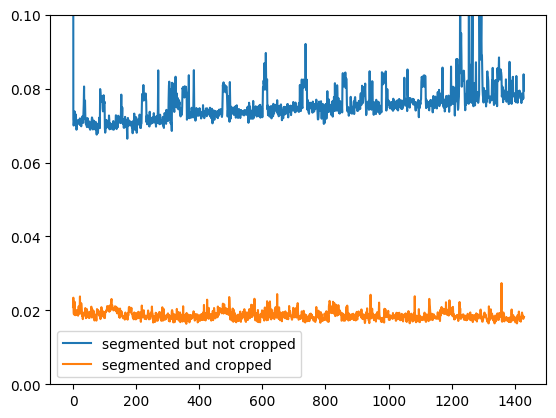

In [17]:
import pandas as pd
plt.ylim(0, 0.1)
plt.plot(timings, label="segmented but not cropped")
plt.plot(timings_2, label="segmented and cropped")
plt.legend()
print(np.average(timings))
print(np.average(timings_2))
print(np.average(timings) / np.average(timings_2))
df = pd.DataFrame()
df['segmented but not cropped'] = timings
df['segmented and cropped'] = timings_2
df.describe()

0.0017510429128900274
0.0005654766843035504
3.0965784469905033


,processing segmented but not cropped,processing segmented and cropped
count,1430.000000,1430.000000
mean,0.001751,0.000565
std,0.000880,0.000105
min,0.001263,0.000461
25%,0.001517,0.000507
50%,0.001688,0.000534
75%,0.001810,0.000568
max,0.032911,0.001361


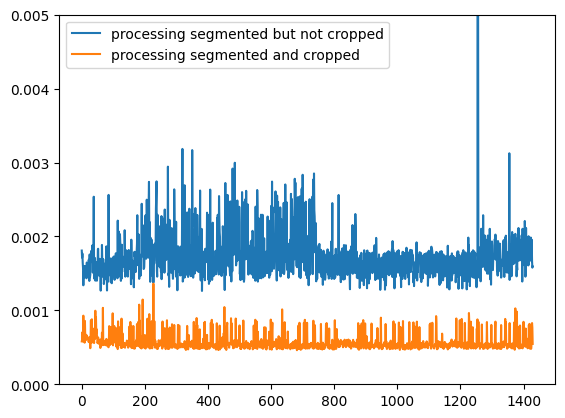

In [18]:
import pandas as pd
plt.ylim(0, 0.005)
plt.plot(p1, label="processing segmented but not cropped")
plt.plot(p2, label="processing segmented and cropped")
plt.legend()
print(np.average(p1))
print(np.average(p2))
print(np.average(p1) / np.average(p2))
df = pd.DataFrame()
df['processing segmented but not cropped'] = p1
df['processing segmented and cropped'] = p2
df.describe()

(640, 640)


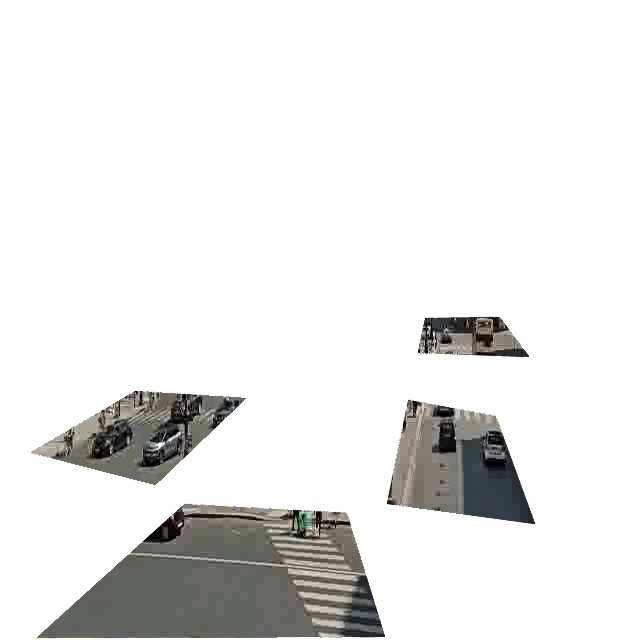

In [12]:
from PIL import Image
img = Image.open('framenocrop.jpg')
print(img.size)
img

(459, 258)


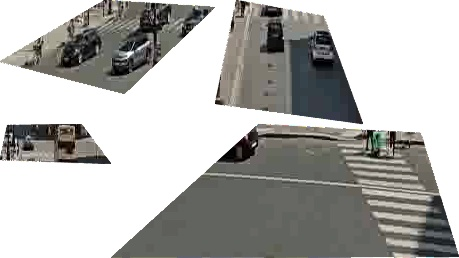

In [13]:
from PIL import Image
img = Image.open('frameoccrop.jpg')
print(img.size)
img